In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import argparse
import os
import pickle
from os import path
import shutil

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import wandb

## Hyper-parameters

In [4]:
hyperparameters = []
smooth_weight = 0.90

# run name format is <env_case>_<exp_type>_<algo_name>_<launch_time>
reset_dir = False

In [5]:
wandb_project = "<wandb/project/name>"
dir_name = "<project/directory>"

smooth_features_of_interest = ["fair/fair_gap", "fair/fair_return", "fair/0/avg_return", "fair/1/avg_return", "fair/2/avg_return", ] 
running_features_of_interest = ["queue/fair_gap", "queue/fair_return", "queue/0/avg_return", "queue/1/avg_return", "queue/2/avg_return", ]

Plotting specific parameters

In [80]:
axis_label_font_size = 24 #18
axis_title_font_size = 28 #20
plt_title_font_size = 24

x_label = "Time-steps" # the label of x-axis
y_label = "Episodic Return" #the label of y-axis
y_lim_bottom = 0 #the bottom limit for the y-axis for fairness gap
output_format = 'pdf' #`pdf`, `png`, or `svg`"

In [41]:
env_dict = {
    "cheetah-family": "Half-Cheetah Variations : Big-Feet vs High-Friction vs Default Half-Cheetah-v3",
}

algo_dict = {
    "lag-ppo": "Lagrangian-PPO",
    "fcpo": "FOC-PPO",
    "ppo": "PPO",
    "m-ppo": "Minimal-PPO",
}

metric_dict = {
    "fair/0/avg_return":"Epsiodic return", 
    "fair/1/avg_return":"Episodic return",
    "fair/2/avg_return":"Episodic return",
    "fair/fair_gap": "Difference in returns", 
    "fair/fair_return": "Cumulative return", 
    "queue/0/avg_return":"Epsiodic return", 
    "queue/1/avg_return":"Episodic return",
    "queue/2/avg_return":"Episodic return",
    "queue/fair_gap": "Difference in returns", 
    "queue/fair_return": "Cumulative return"
}

title_dict = {
    "fair/0/avg_return":"Big-feet subgroup",
    "fair/1/avg_return":"High-friction subgroup",
    "fair/2/avg_return":"Default subgroup",
    "fair/fair_gap": "Fairness gap, $\epsilon$", 
    "fair/fair_return": "All subgroups", 
    "queue/0/avg_return":"Big-feet subgroup",
    "queue/1/avg_return":"High-friction subgroup",
    "queue/2/avg_return":"Default subgroup",
    "queue/fair_gap": "Fairness gap, $\epsilon$", 
    "queue/fair_return": "All subgroups"
}

## Get data from WandB

In [19]:
api = wandb.Api(timeout=200)

In [9]:
def all_features_present(summary):
    """
    checks if all metrics are present in the run
    :param summary:
    :return:
    """
    okay = True
    for feature in smooth_features_of_interest + running_features_of_interest + ["global_step"]:
        okay = okay and (feature in summary)
    return okay

In [10]:
# delete the cached runs if specified
if reset_dir:
    try:
        shutil.rmtree(dir_name)
    except OSError as e:
        print("Error: %s - %s." % (e.filename, e.strerror))

# else load from the cache
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
    with open(f"{dir_name}/cache.pkl", "wb") as handle:
        pickle.dump([[], [], [], {}, [], set([])], handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f"{dir_name}/cache.pkl", "rb") as handle:
    summary_list, config_list, name_list, envs, exp_names, ids = pickle.load(handle)

In [20]:
# Get all the runs in the project
runs = api.runs(wandb_project)
data = []

for idx, run in enumerate(runs):
    
    # if the current run is not saved already
    if run.id not in ids and run.config["env_case"]=="cheetah-family":
        
        ids.add(run.id) # update the saved run history
        print(f"Adding run {run.id}")

        if all_features_present(run.summary) and run.state == "finished":
            # Note: WandB api is shaky, the samples we get for each are different in run.scan_history
            metric_history = run.scan_history(keys=smooth_features_of_interest + running_features_of_interest + ["global_step"])
            metric_data = [(row[smooth_features_of_interest[0]], row[smooth_features_of_interest[1]],
                            row[smooth_features_of_interest[2]], row[smooth_features_of_interest[3]], row[smooth_features_of_interest[4]],
                            row[running_features_of_interest[0]], row[running_features_of_interest[1]],
                            row[running_features_of_interest[2]], row[running_features_of_interest[3]], row[running_features_of_interest[4]],
                            row["global_step"]) for row in metric_history]
            
            metrics_dataframe = pd.DataFrame(metric_data, columns=smooth_features_of_interest + running_features_of_interest + ["global_step"])
            
            if metrics_dataframe.empty:
                raise Exception(f"Something unexpected hapened with run:{run.id}, with {run.config['exp_name']} and seed {run.config['seed']}")
            
            # data collected!
            # exp_name = <exp_type>_<algo>
            # where exp_type = <exp_subname>_<eps> for fair algorithms and just <exp_subname> for unfair algos
            exp_name = run.config["exp_name"]

            # get the algo and add it as a column
            algo_name = exp_name.split("_")[-1]
            metrics_dataframe.insert(len(metrics_dataframe.columns), "algo", algo_name)

            # get runs for all corresponding params tuned (eg nu_lr)
            for param in hyperparameters:
                if param in run.config:
                    # update the exp_name to reflect the hyperparam value
                    exp_name += "-" + param + "-" + str(run.config[param]) + "-"
                    # creates a separate entry for each hyperparameter
            metrics_dataframe.insert(len(metrics_dataframe.columns), "exp_name", exp_name)

            # add the exp to the exp_name list
            exp_names += [exp_name]

            # add the seed also as a column in df
            metrics_dataframe.insert(len(metrics_dataframe.columns), "seed", run.config["seed"])
            
            # add the df to the all data
            data += [metrics_dataframe]

            # if the env is not previously seen
            if run.config["env_case"] not in envs:
                # add to the envs dict
                envs[run.config["env_case"]] = [metrics_dataframe]
            else:
                # else, append the current data to the already present env log
                envs[run.config["env_case"]] += [metrics_dataframe]

            # update the summary_list, config_list and name_list
            # run.summary are the output key/values like accuracy.  We call ._json_dict to omit large files
            summary_list.append(run.summary._json_dict)

            # run.config is the input metrics.  We remove special values that start with _.
            config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

            # run.name is the name of the run.
            name_list.append(run.name)

# Convert all the df to a unified df
summary_df = pd.DataFrame.from_records(summary_list)
config_df = pd.DataFrame.from_records(config_list)
name_df = pd.DataFrame({"name": name_list})
all_df = pd.concat([name_df, config_df, summary_df], axis=1)
# data = pd.concat(data, ignore_index=True)
with open(f"{dir_name}/cache.pkl", "wb") as handle:
    pickle.dump([summary_list, config_list, name_list, envs, exp_names, ids], handle, protocol=pickle.HIGHEST_PROTOCOL)
print("data loaded")

data loaded


# Plotting

In [12]:
# create paths for storing plots
if not os.path.exists(f"{dir_name}/data/smooth"):
    os.makedirs(f"{dir_name}/data/smooth")
if not os.path.exists(f"{dir_name}/data/running"):
    os.makedirs(f"{dir_name}/data/running")

if not os.path.exists(f"{dir_name}/plots/smooth"):
    os.makedirs(f"{dir_name}/plots/smooth")
if not os.path.exists(f"{dir_name}/plots/running"):
    os.makedirs(f"{dir_name}/plots/running")

## Color schemes

In [76]:
# sns.set(style="darkgrid")
sns.set(style="white")

In [43]:
current_palette = sns.color_palette(n_colors=len(algo_dict))
current_palette_dict = dict(zip(algo_dict.keys(), current_palette))
current_palette_dict

{'lag-ppo': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 'fcpo': (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 'ppo': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 'm-ppo': (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)}

## Plotting utilities

In [44]:
def get_interested_exp_names(name, epsilon, skip_minimal=False):
    """
    exp_name format is:
    for unfair algo: <name>_<algo>
    for fair algo: <name>_eps_<epsilon>_<algo>
    """
    interested_exp_names = []
    for algo in algo_dict.keys():
        if skip_minimal and algo=="m-ppo":
            continue
        
        if algo == "ppo" or algo == "m-ppo":
            exp_name = f"{name}_{algo}"
        else:
            exp_name = f"{name}_eps_{epsilon}_{algo}"
        
        assert exp_name in set(exp_names), f"Exp {exp_name} not found!!"

        interested_exp_names += [exp_name]
        
    return sorted(interested_exp_names)

In [16]:
# apply smoothing to the interested quantities

# https://stackoverflow.com/questions/42281844/what-is-the-mathematics-behind-the-smoothing-parameter-in-tensorboards-scalar#_=_
def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)  # Save it
        last = smoothed_val  # Anchor the last smoothed value

    return smoothed

def _smooth(df_orig):
    df = df_orig.copy()
    for feature in smooth_features_of_interest:
        df[feature] = smooth(list(df[feature]), smooth_weight)
    return df

In [83]:
def plot_metrics(df, eps, env, mode, save=True):
    """
    the main plotting function
    """
    width = 6 * 5
    height = 6  * 1 
    
    if mode == "smooth":
        features_of_interest = smooth_features_of_interest
    elif mode == "running":
        features_of_interest = running_features_of_interest
    else:
        raise Exception("unknown mode")
    
    fig, ax = plt.subplots(1, 5, figsize=(width, height))
    
    for idx, feature in enumerate(features_of_interest): 
        sns.lineplot(data=df, x="global_step", y=feature, hue="algo", ci="sd", palette=current_palette_dict, ax=ax[idx])
        ax[idx].ticklabel_format(style="sci", scilimits=(0, 0), axis="x")
        ax[idx].set(xlabel=x_label, ylabel=metric_dict[feature])
        ax[idx].legend().remove()
        ax[idx].set_title(title_dict[feature])
        
        ax[idx].title.set_size(axis_title_font_size)
        ax[idx].xaxis.label.set_size(axis_label_font_size)
        ax[idx].yaxis.label.set_size(axis_label_font_size)
        
    # for fairness gap indicate the threshold also
    ax[0].axhline(y=eps,c="black",linestyle="--")
    
    # https://stackoverflow.com/a/45161551
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # https://stackoverflow.com/a/46267860
    fig.subplots_adjust(bottom=0.3, wspace=0.33)
    handles, labels = ax[0].get_legend_handles_labels()
    # remove the first redundant lable
    handles = handles[1:]
    labels = [algo_dict[label] for label in labels[1:]]
    
    # https://stackoverflow.com/a/9764364
    labels, handles = (list(t) for t in zip(*sorted(zip(labels, handles))))
    
    ax[1].legend(handles = handles , labels= labels, prop={'size':20}, 
                 loc='upper center', 
                 bbox_to_anchor=(0., -0.2),fancybox=False, shadow=False, ncol=4)
    
    if save:
        plt.savefig(f"{dir_name}/plots/{mode}/{env}_eps_{eps}.{output_format}")
    plt.show()
    plt.clf()

In [21]:
set(all_df["env_case"])

{'cheetah-family'}

In [65]:
config_df.epsilon.unique()

array([  500, 10000,  1000])

# Loop over envs and plot

In [23]:
redo_smooth = True

eps_list = config_df.epsilon.unique()
int_exp_suffix = "cheetah_final" # plot corresponding to this experiment name

## Plotting smoothed plots

cheetah-family, eps=500, seeds=10


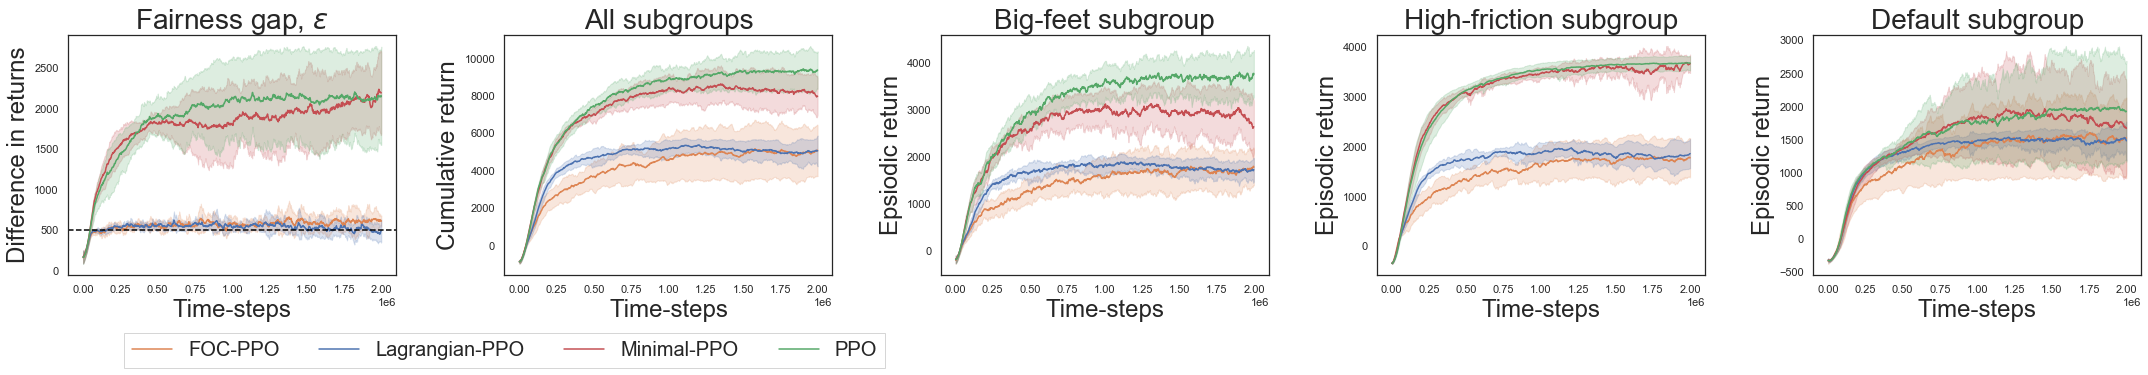

cheetah-family, eps=10000, seeds=10


<Figure size 432x288 with 0 Axes>

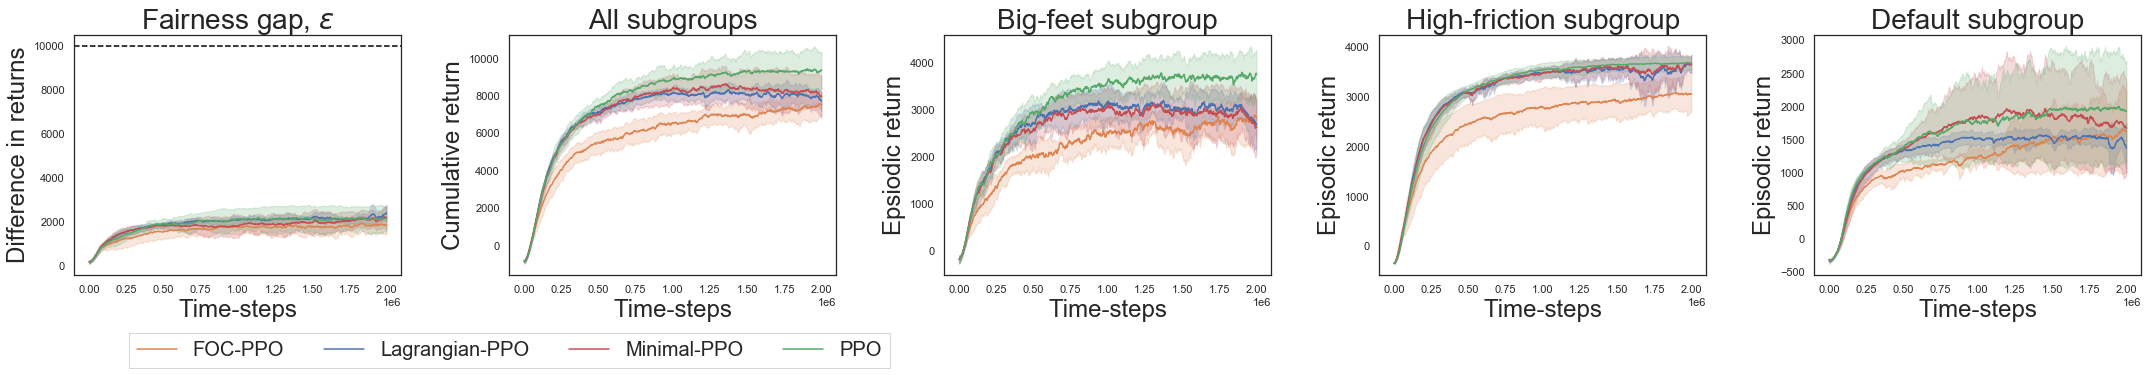

cheetah-family, eps=1000, seeds=10


<Figure size 432x288 with 0 Axes>

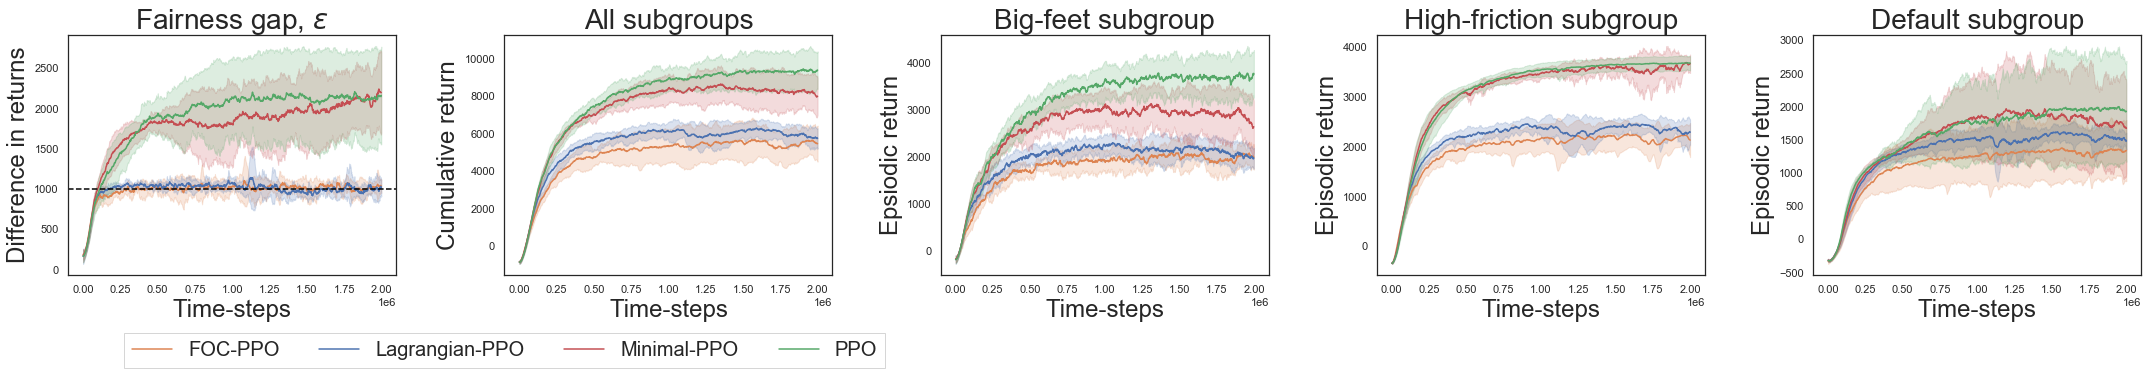

<Figure size 432x288 with 0 Axes>

In [85]:
for env in set(all_df["env_case"]):
    
    data = None
    
    # Load data for env
    if redo_smooth or not path.exists(f"{dir_name}/data/smooth/{env}.pkl"):
        with open(f"{dir_name}/data/smooth/{env}.pkl", "wb") as handle:
            # smooth the indvidual runs
            smoothed_dfs = []
            for df in envs[env]:
                smoothed_dfs += [_smooth(df)] 
            data = pd.concat(smoothed_dfs, sort=True)   
            # Alternate option, can get data without smoothing and perform smoothing later 
            # data = pd.concat(envs[env], sort=True)  
            assert data.shape[0] == envs[env][0].shape[0] * len(envs[env])
            data["seed"] = data["seed"].astype(float)
            for feature in smooth_features_of_interest:
                data[feature] = data[feature].astype(float)
            pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(f"{dir_name}/data/smooth/{env}.pkl", "rb") as handle:
            data = pickle.load(handle)
        print(f"{env}'s data loaded from cache")
    
    # ----------------------------------------------------------------
    #               Actual plotting calls here
    # ----------------------------------------------------------------
    
    for eps in eps_list:
        
        # get interested exp names 
        interested_exp_names =  get_interested_exp_names(int_exp_suffix, eps, skip_minimal=False)
    
        # plot for one <env>_<eps> combination
        plot_data = data.groupby(["seed", "algo"]).apply(lambda x: x)
        plot_data = plot_data.loc[plot_data["exp_name"].isin(interested_exp_names)]
        
        print(f"{env}, eps={eps}, seeds={len(plot_data.seed.unique())}")

        # plot 
        plot_metrics(plot_data, eps, env, mode="smooth", save=True)
        
        

## Plotting Running Plots

cheetah-family's data loaded from cache
cheetah-family, eps=500, seeds=10


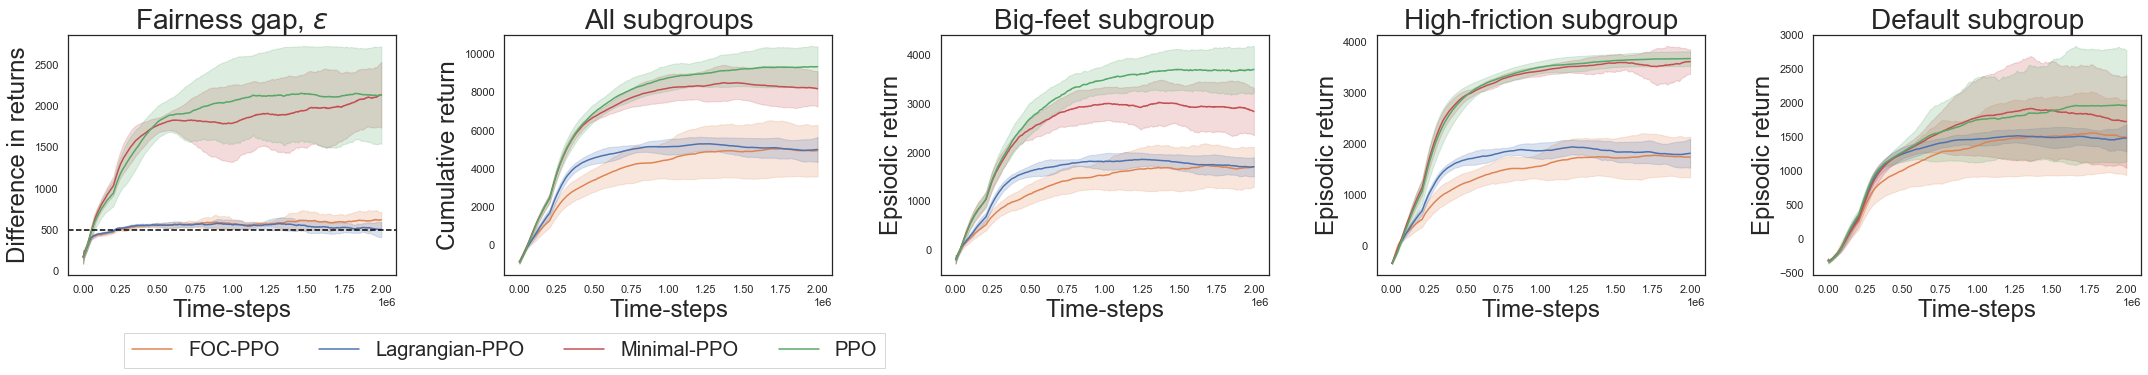

cheetah-family, eps=10000, seeds=10


<Figure size 432x288 with 0 Axes>

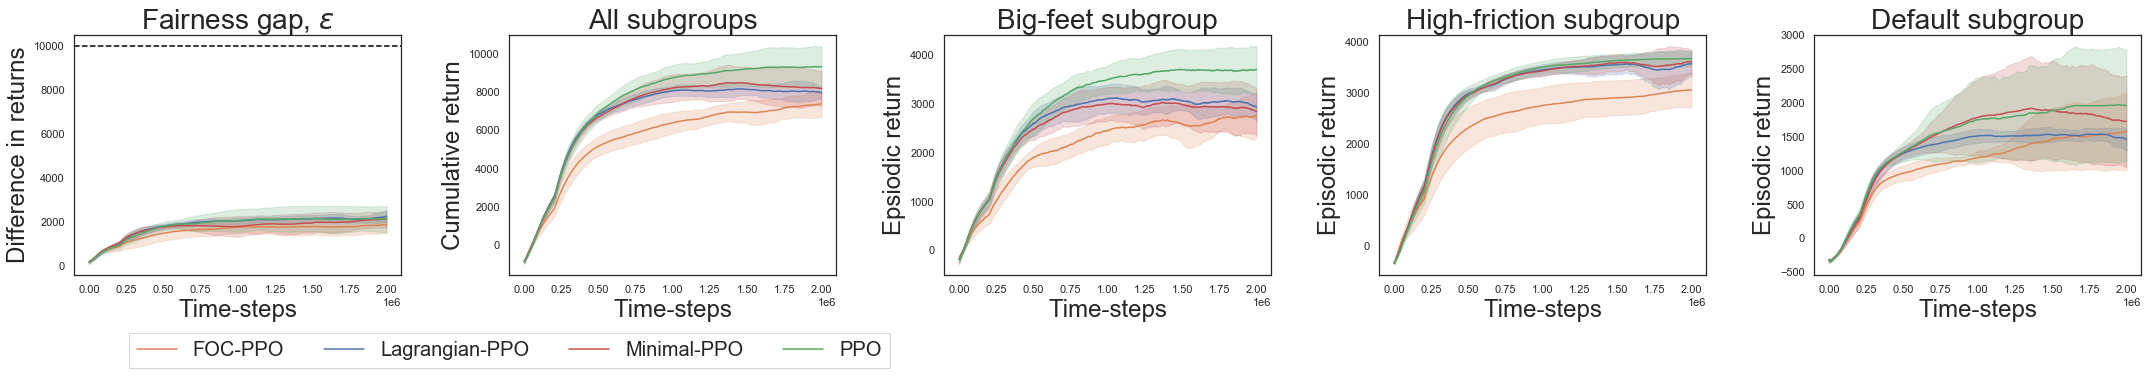

cheetah-family, eps=1000, seeds=10


<Figure size 432x288 with 0 Axes>

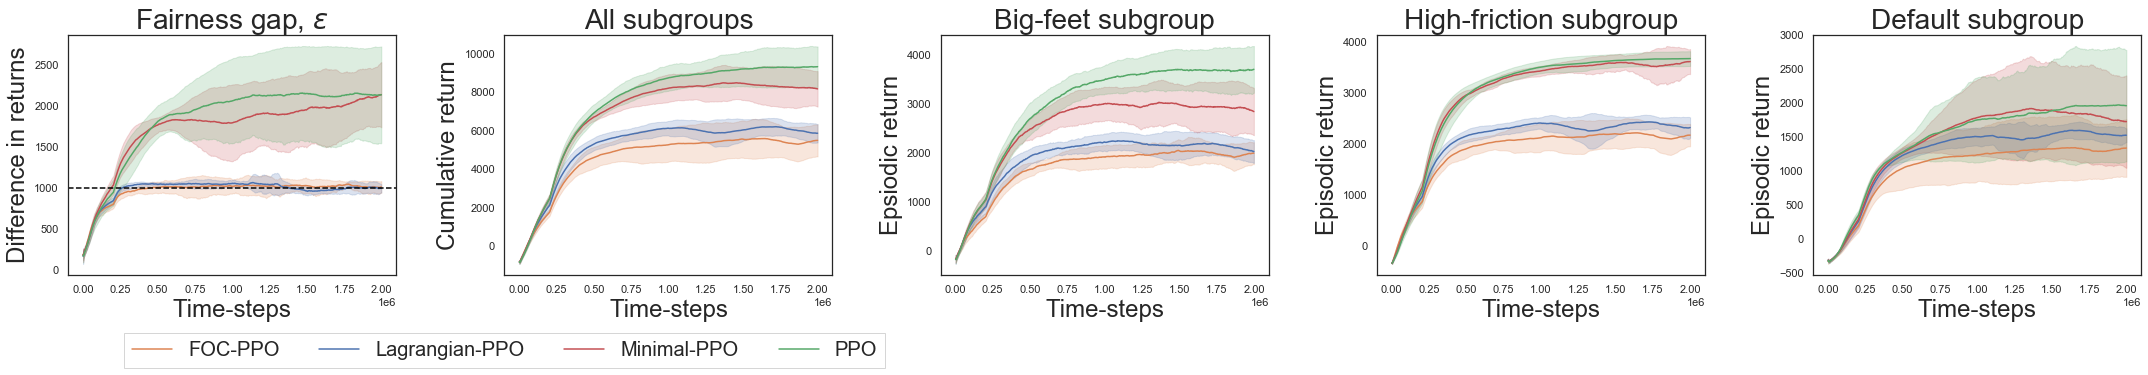

<Figure size 432x288 with 0 Axes>

In [86]:
for env in set(all_df["env_case"]):
    
    data = None
    
    # Load data for env
    if not path.exists(f"{dir_name}/data/running/{env}.pkl"):
        with open(f"{dir_name}/data/running/{env}.pkl", "wb") as handle:
            data = pd.concat(envs[env], sort=True)  
            assert data.shape[0] == envs[env][0].shape[0] * len(envs[env])
            data["seed"] = data["seed"].astype(float)
            for feature in running_features_of_interest:
                data[feature] = data[feature].astype(float)
            pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open(f"{dir_name}/data/running/{env}.pkl", "rb") as handle:
            data = pickle.load(handle)
        print(f"{env}'s data loaded from cache")
    
    # ----------------------------------------------------------------
    #               Actual plotting calls here
    # ----------------------------------------------------------------
    
    for eps in eps_list:
        
        # get interested exp names 
        interested_exp_names =  get_interested_exp_names(int_exp_suffix, eps, skip_minimal=False)
    
        # plot for one <env>_<eps> combination
        plot_data = data.groupby(["seed", "algo"]).apply(lambda x: x)
        plot_data = plot_data.loc[plot_data["exp_name"].isin(interested_exp_names)]
        
        print(f"{env}, eps={eps}, seeds={len(plot_data.seed.unique())}")

        # plot 
        plot_metrics(plot_data, eps, env, mode="running", save=True)        
        